<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/population_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import external packages

In [1]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 16.5 MB/s eta 0:00:00


In [2]:
import geemap
import ee
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import json

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Utility Functions

- Create a standard function to apply filters on image collection

In [3]:
def filterImageCollection(
        image_collection_id: str,
        geometry: ee.geometry.Geometry,
        date_range: tuple[str]
    ) -> ee.imagecollection.ImageCollection:

    imageCollection = ee.ImageCollection(image_collection_id)
    d1,d2 = date_range
    filtered = imageCollection.filter(
        ee.Filter.date(d1, d2) ## Filter by date
    ).filter(
        ee.Filter.bounds(geometry) ## Filter by bounds
    )

    return filtered

def kelvin_to_celsius(image):
    temp = image.multiply(0.02).subtract(273.15).rename('temp_C')
    return image.addBands(temp).copyProperties(image, ['system:time_start'])

In [4]:
## get the current dates
today = datetime.now()
d1 = today - timedelta(days=30)
current_date_range = (d1.date().strftime('%Y-%m-%d'), today.date().strftime('%Y-%m-%d'))
current_date_range

('2024-04-06', '2024-05-06')

## Visualizing satellite RGB image

In [31]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

--2024-05-06 12:13:00--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-06 12:13:00--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.01s   

2024-05-06 12:13:01 (7.13 MB/s) - ‘g

In [112]:
gurgaon_gdf = gpd.read_file('gurgaon.gpkg', crs='EPSG:4326')
geojson = gurgaon_gdf.to_json()

## Convert the geopackage file to ee.Geometry
featureCollection = ee.FeatureCollection(json.loads(geojson))
geometry = featureCollection.geometry()

## world population data

[how world population is estimated](https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/)

In [ ]:
world_pop_image = ee.ImageCollection("WorldPop/GP/100m/pop")\
.filter(ee.Filter.eq('country','IND'))\
.filter(ee.Filter.eq('year', 2020))\
.first().clip(geometry)

In [130]:
center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)
Map = geemap.Map(center=center, zoom=10)
boundary_viz_params = {
    'color':'red',
    "width":2,
    "lineType":"solid",
    'fillColorOpacity': 0.1
}
Map.addLayer(ee_object=geometry, vis_params=boundary_viz_params, name='Gurgaon Boundary')
viz_params = {
    'min': 0,
    'max': 50,
    'bands': ['population']
}
Map.addLayer(world_pop_image, viz_params, name='Population')
Map

Map(center=[28.437398083125167, 77.06463665845695], controls=(WidgetControl(options=['position', 'transparent_…

In [131]:
geemap.ee_export_image(
    world_pop_image,
    filename='population.tif',
    scale=100,
    file_per_band=False,
    region=geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/population.tif


## Converting the raster to xyz point data


In [135]:
xds = rioxarray.open_rasterio('population.tif')\
        .sel(band=1)\
        .to_pandas()

xds = xds.stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: 'population'})
print(xds.shape)
xds.head()

(19370, 3)


,lat,lng,population
0,28.510111,77.003728,18.283073
1,28.510111,77.004627,29.219259
2,28.510111,77.005525,32.136192
3,28.510111,77.006423,33.248539
4,28.510111,77.007322,32.943436


## Clip the dataframe within the polygon

- First extract the coordinates of the `google earth engine Geometry object`
- Then convert the coordinates to a `shapely.geometry.Polygon`
- Use this geomtry to filter out the h3 spatial index from the dataframe

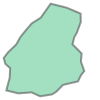

In [137]:
aoi = gurgaon_gdf['geometry'].iloc[0]
aoi

In [138]:
xds['geometry'] = list(map(Point, zip(xds['lng'], xds['lat'])))
gdf = gpd.GeoDataFrame(xds, crs='EPSG:4326', geometry='geometry')
print(f"Total of {gdf.shape[0]} points are in the dataset")
gdf.sample(2)

Total of 19370 points are in the dataset


,lat,lng,population,geometry
15293,28.405008,77.078289,30.647345,POINT (77.07829 28.40501)
5100,28.475077,77.030678,88.561729,POINT (77.03068 28.47508)


In [139]:
gdf = gdf[gdf['geometry'].within(aoi)]
print(f"After clipping the points, now {gdf.shape[0]} points remain in the dataset")

After clipping the points, now 12925 points remain in the dataset


## Converting to H3 spatial index

We have now temperature for each coordinate. We need to convert them to h3 spatial index for visualization

**why visualizing the data with h3 spatial index ?**

- Better compatibility with other visualization tools
- Faster visualization
- requires less space to store the data
- Performance and Scalability: H3 is designed for scalability and performance, making it suitable for real-time or dynamic visualizations of large-scale geospatial datasets

In [140]:
APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)
hex_col

'hex8'

In [141]:
gdf.shape

(12925, 4)

In [159]:
# find hexs containing the points
gdf[hex_col] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)
gdf.sample(5)

,lat,lng,population,geometry,hex8
14147,28.413093,77.099848,28.573101,POINT (77.09985 28.41309),883da11881fffff
7107,28.461602,77.081882,75.496796,POINT (77.08188 28.46160),883da11a95fffff
16916,28.393330,77.018101,26.148664,POINT (77.01810 28.39333),883da11867fffff
15696,28.402314,77.089967,32.607071,POINT (77.08997 28.40231),883da118a9fffff
7111,28.461602,77.085475,84.726875,POINT (77.08548 28.46160),883da11a95fffff


In [170]:
# calculate temperature average per hex
pop_hex_data = gdf.groupby(hex_col)['population'].sum().to_frame('population').reset_index()
print(pop_hex_data.shape)
pop_hex_data.sample(5)

(175, 2)


,hex8,population
114,883da119d3fffff,103.694908
156,883da11ac3fffff,6240.176270
164,883da11ad7fffff,5112.195312
57,883da11849fffff,5280.210938
97,883da118d5fffff,4751.849609


After creating the hexagons using the h3 spatial index, the point data are reduced to 3545 from 299484.This saves a significant amount of disk space.

Also compared to geometries which are mostly having coordinates with float numbers, it is more efficient to store a h3 index as it is a string object with fixed number of characters (15-16 characters)

To view the h3 spatial indices, check out this [Uber h3 viewer](https://wolf-h3-viewer.glitch.me/)

## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

In [192]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## removing negative count
    xdf = xdf[xdf[value_col]>0]

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].astype(int)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

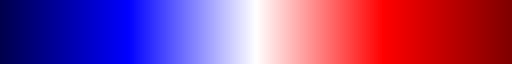

In [188]:
## Choose a colormap
cmap = colormaps['seismic']
cmap

Generating the tooltip:

In [189]:
tooltip = {
        "html": "<b>Population</b>: {population}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

## Finally plotting the results on a 3D map

In [191]:
## Apply the colormap to the dataframe
xdf = colormap_dataframe(df=pop_hex_data, value_col='population', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100.0,
          "B": 255.0,
          "G": 45.0,
          "R": 45.0,
          "hex8": "883da10341fffff",
          "population": 2285
        },
        {
          "A": 100.0,
          "B": 177.0,
          "G": 177.0,
          "R": 255.0,
          "hex8": "883da10345fffff",
          "population": 4454
        },
        {
          "A": 100.0,
          "B": 61.0,
          "G": 61.0,
          "R": 255.0,
          "hex8": "883da10349fffff",
          "population": 5308
        },
        {
          "A": 100.0,
          "B": 171.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da1034bfffff",
          "population": 1057
        },
        {
          "A": 100.0,
          "B": 221.0,
          "G": 221.0,
          "R": 255.0,
          "hex8": "883da1034dfffff",
          "population": 4122
        },
        {
          "A": 100.0,
          "B": 112.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da10361fffff",
          "population": 419
        },
        {
          "A": 100.0,
          "B": 255.0,
          "G": 61.0,
          "R": 61.0,
          "hex8": "883da10365fffff",
          "population": 2410
        },
        {
          "A": 100.0,
          "B": 213.0,
          "G": 213.0,
          "R": 255.0,
          "hex8": "883da10369fffff",
          "population": 4168
        },
        {
          "A": 100.0,
          "B": 84.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da1036bfffff",
          "population": 113
        },
        {
          "A": 100.0,
          "B": 157.0,
          "G": 157.0,
          "R": 255.0,
          "hex8": "883da1036dfffff",
          "population": 4598
        },
        {
          "A": 100.0,
          "B": 118.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da11137fffff",
          "population": 496
        },
        {
          "A": 100.0,
          "B": 236.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da11185fffff",
          "population": 1744
        },
        {
          "A": 100.0,
          "B": 0.0,
          "G": 0.0,
          "R": 231.0,
          "hex8": "883da111a1fffff",
          "population": 6112
        },
        {
          "A": 100.0,
          "B": 0.0,
          "G": 0.0,
          "R": 205.0,
          "hex8": "883da111a3fffff",
          "population": 6502
        },
        {
          "A": 100.0,
          "B": 0.0,
          "G": 0.0,
          "R": 193.0,
          "hex8": "883da111a5fffff",
          "population": 6707
        },
        {
          "A": 100.0,
          "B": 0.0,
          "G": 0.0,
          "R": 223.0,
          "hex8": "883da111a7fffff",
          "population": 6258
        },
        {
          "A": 100.0,
          "B": 5.0,
          "G": 5.0,
          "R": 255.0,
          "hex8": "883da111a9fffff",
          "population": 5725
        },
        {
          "A": 100.0,
          "B": 153.0,
          "G": 153.0,
          "R": 255.0,
          "hex8": "883da111abfffff",
          "population": 4637
        },
        {
          "A": 100.0,
          "B": 0.0,
          "G": 0.0,
          "R": 167.0,
          "hex8": "883da111adfffff",
          "population": 7077
        },
        {
          "A": 100.0,
          "B": 255.0,
          "G": 193.0,
          "R": 193.0,
          "hex8": "883da111b5fffff",
          "population": 3407
        },
        {
          "A": 100.0,
          "B": 244.0,
          "G": 0.0,
          "R": 0.0,
          "hex8": "883da111bdfffff",
          "population": 1841
        },
        {
          "A": 100.0,
          "B": 255.0,
          "G": 145.0,
          "R": 145.0,
          "hex8": "883da111e1fffff",
          "population": 3

## Reference

1. [Create a choropleth map using h3 and plotly](https://medium.com/@ransaka/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-c65555744c87)

2. [Uber h3 py notebook](https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb)

3. [All available matplotlib colormaps for plotting](https://matplotlib.org/stable/users/explain/colors/colormaps.html)